In [2]:
!pip install -U d2l

     |████████████████████████████████| 81kB 5.3MB/s 


# 3.2. Linear Regression Implementation from Scratch (Lesson)

In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [6]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.2680, 1.1229]) 
label: tensor([0.9110])


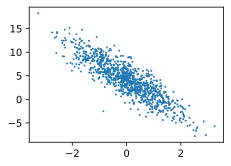

In [7]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

In [23]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [45]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.6311, -1.1824],
        [-0.2370, -2.2912],
        [-0.6364,  0.1664],
        [ 0.9399, -0.7286],
        [-0.1663, -0.9424],
        [-0.5542,  0.5075],
        [ 0.5722,  0.5346],
        [-1.5923, -1.3764],
        [-1.8809, -0.9249],
        [-2.0888, -1.2465]]) 
 tensor([[ 9.4579],
        [11.5212],
        [ 2.3625],
        [ 8.5534],
        [ 7.0593],
        [ 1.3697],
        [ 3.5246],
        [ 5.6932],
        [ 3.5715],
        [ 4.2778]])


In [32]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [40]:
# The model
def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b

# The loss function
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

# The optimization algorithm
def sgd(params, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [53]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000063
epoch 2, loss 0.000056
epoch 3, loss 0.000056


In [35]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([9.8228e-04, 6.8903e-05], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0001], grad_fn=<RsubBackward1>)


# 3.2. Linear Regression Implementation from Scratch (Exercises)

1. Since this is a convex optimization problem, initiliazing the weights to zero will not have any consequences.

2. **Ohm's Law**: V = IR
Yes, we can learn the relationship using auto differentiation. We do not need the additional bias parameter.

5. Not required in the PyTorch implementation.

6. When the learning rate is higher, the updates will take larger steps. But if it is too high, then the steps will be so large that it will sometime pass the minima over to the other side. So it is important to find the middle ground.

7. The last batch will be smaller.

# 3.3. Concise Implementation of Linear Regression (Lesson)

In [54]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [55]:
def load_array(data_arrays, batch_size, is_train=True):  
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [56]:
next(iter(data_iter))

[tensor([[-0.4463, -0.5349],
         [-0.1792,  0.6422],
         [-1.5496,  2.0619],
         [ 0.8262, -0.1099],
         [-3.1732, -0.3586],
         [-0.1952, -0.3250],
         [ 0.7236,  1.2994],
         [ 0.9384,  0.1685],
         [-1.8432, -0.3324],
         [ 0.0249,  0.0905]]), tensor([[ 5.1424],
         [ 1.6361],
         [-5.9162],
         [ 6.2283],
         [-0.9197],
         [ 4.9141],
         [ 1.2314],
         [ 5.5024],
         [ 1.6294],
         [ 3.9401]])]

In [57]:
# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [58]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [60]:
# The loss function
loss = nn.MSELoss()
# The optimization algorithm
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [61]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000149
epoch 2, loss 0.000098
epoch 3, loss 0.000099


In [62]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([0.0012, 0.0006])
error in estimating b: tensor([0.0005])


# 3.3. Concise Implementation of Linear Regression (Exercises)

1. The default reduction is mean. If the sum is used instead, the loss will be n (number of training samples) times the value returned by mean. So, to achieve an identical result, we will have to divide the learning rate by n.

2. See the next cell

3. net[0].weight.grad

In [65]:
# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# The loss function
loss = nn.SmoothL1Loss()
# The optimization algorithm
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

epoch 1, loss 2.240423
epoch 2, loss 0.377992
epoch 3, loss 0.001063
error in estimating w: tensor([ 0.0237, -0.0353])
error in estimating b: tensor([0.0124])


In [68]:
print(net[0].weight.grad)

tensor([[-0.0057,  0.0760]])


# 3.5. The Image Classification Dataset (Lesson)

In [69]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [70]:
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True,
                                                transform=trans,
                                                download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False,
                                               transform=trans, download=True)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [72]:
print(len(mnist_train), len(mnist_test))
print(mnist_train[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


In [74]:
def get_fashion_mnist_labels(labels):  
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [75]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

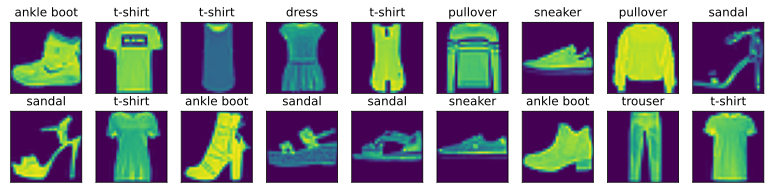

In [76]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [89]:
batch_size = 256

def get_dataloader_workers():  
    """Use 4 processes to read the data."""
    return 1

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [90]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'


'4.49 sec'

In [84]:
def load_data_fashion_mnist(batch_size, resize=None):  
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [86]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([1, 1, 64, 64]) torch.float32 torch.Size([1]) torch.int64


# 3.5. The Image Classification Dataset (Exercises)

1. Yes. It increases the time significantly. (it increased the time by 20 times, although tried only once.)

2. One way to make the implementation faster would be to load the dataset into the memory. However it would not be feasible in most cases with large datasets.

One good thing about the pytorch dataloader is that it works on parallel. So, when the model is working on the training, the dataloader will bring on the new batches. So, it would be possible to make it faster by using a larger number in the num_workers parameter.

3. See next cell.

In [94]:
import torchvision.datasets
print(dir(torchvision.datasets))

['CIFAR10', 'CIFAR100', 'Caltech101', 'Caltech256', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'DatasetFolder', 'EMNIST', 'FakeData', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'HMDB51', 'ImageFolder', 'ImageNet', 'KMNIST', 'Kinetics400', 'LSUN', 'LSUNClass', 'MNIST', 'Omniglot', 'PhotoTour', 'Places365', 'QMNIST', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SVHN', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'caltech', 'celeba', 'cifar', 'cityscapes', 'coco', 'fakedata', 'flickr', 'folder', 'hmdb51', 'imagenet', 'kinetics', 'lsun', 'mnist', 'omniglot', 'phototour', 'places365', 'sbd', 'sbu', 'semeion', 'stl10', 'svhn', 'ucf101', 'usps', 'utils', 'video_utils', 'vision', 'voc', 'widerface']


# 3.6. Implementation of Softmax Regression from Scratch

In [95]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [96]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [97]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

In [98]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [99]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2182, 0.1102, 0.2218, 0.1783, 0.2715],
         [0.0974, 0.3720, 0.0717, 0.3507, 0.1082]]), tensor([1.0000, 1.0000]))

In [100]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [101]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [102]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)


tensor([2.3026, 0.6931])

In [104]:
def accuracy(y_hat, y):  
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [105]:
print(accuracy(y_hat, y) / len(y))

0.5


In [106]:
def evaluate_accuracy(net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [107]:
class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [108]:
evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.0844

In [109]:
def train_epoch_ch3(net, train_iter, loss, updater):  
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [110]:
class Animator: 
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [111]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [112]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

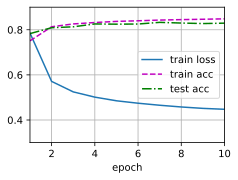

In [114]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


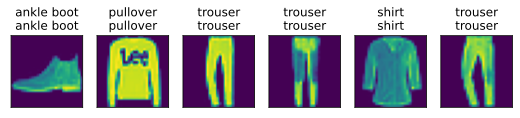

In [115]:
def predict_ch3(net, test_iter, n=6): 
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# 3.6. Implementation of Softmax Regression from Scratch (Exercises)

1. For a sufficiently large value x (x>1024), e^x will overflow.

2. log(0) = undefined

3. We can use gradient clipping to make sure that the exponentiation does not become too large. To solve the log(0) problem, we can add a very small constant (.000000001) to the terms.

4. I would like to see the probability distribution over all the cases in some cases. For exmaple, in medical domain, I think it would be beneficial to include humans in the loop.

5. If the vocabulary is very large, the softmax probabilities might become too small for all the words.

# 3.7. Concise Implementation of Softmax Regression (Lesson)

In [116]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [117]:
# PyTorch does not implicitly reshape the inputs. Thus we define the flatten
# layer to reshape the inputs before the linear layer in our network
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [119]:
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

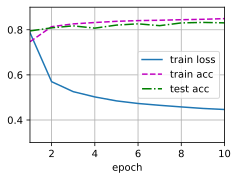

In [120]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 3.7. Concise Implementation of Softmax Regression (Exercises)

2. The test accuracy decreases after a while because the model starts to overfit the training sample at that point. There are a number of ways to overcome this problem, for example, regularization, data augmentation, simpler models, and early stopping.

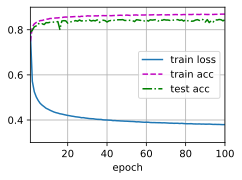

In [122]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# PyTorch does not implicitly reshape the inputs. Thus we define the flatten
# layer to reshape the inputs before the linear layer in our network
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 100
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)